In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 161M/161M [00:03<00:00, 45.9MB/s] 

Extracting files...


Path to dataset files: /Users/richardmacairm1/.cache/kagglehub/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/versions/1


No se encontró ningún archivo ZIP. Revisa la descarga.


In [34]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalización específica para EfficientNet
    rotation_range=20,
    width_shift_range=0.15,
    zoom_range=[0.7, 1.3],
    shear_range=5,
    validation_split=0.2
)

# Generadores (igual que antes):
data_gen_entrenamiento = train_datagen.flow_from_directory(
    "Maiz",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training"
)

data_gen_pruebas = train_datagen.flow_from_directory(
    "Maiz",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation"
)



Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [35]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# 1. Base Model CON descongelación parcial
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling=None  # Salida 4D para Conv2D
)

# Descongelar SOLO las últimas 15 capas
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# 2. Modelo con capas personalizadas
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),  # Más filtros
    layers.MaxPooling2D(2,2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# 3. Compilación con LR bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    data_gen_entrenamiento,
    validation_data=data_gen_pruebas,
    epochs=50,  # Máximo de épocas
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.3682 - loss: 1.3919 - val_accuracy: 0.7213 - val_loss: 0.8398
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 336ms/step - accuracy: 0.5859 - loss: 0.9811 - val_accuracy: 0.8182 - val_loss: 0.6121
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 344ms/step - accuracy: 0.7299 - loss: 0.7382 - val_accuracy: 0.8493 - val_loss: 0.4696
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 334ms/step - accuracy: 0.7771 - loss: 0.6117 - val_accuracy: 0.8708 - val_loss: 0.4032
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.7979 - loss: 0.5447 - val_accuracy: 0.8900 - val_loss: 0.3432
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 335ms/step - accuracy: 0.8388 - loss: 0.4625 - val_accuracy: 0.8971 - val_loss: 0.3142
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 352ms/step - accuracy: 0.8517 - loss: 0.4196 - val_accuracy: 0.9055 - val_loss: 0.2855
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 355ms/step - accuracy: 0.8719 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicción: Common_Rust (31.82% de confianza)


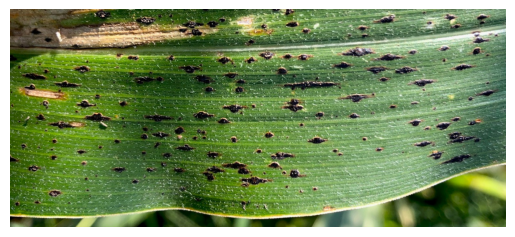

In [49]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def predecir_enfermedad(ruta_imagen):
    # 1. Cargar y redimensionar
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(2400, 2400))
    
    # 2. Convertir a array y aplicar PREPROCESAMIENTO CORRECTO
    img_array = tf.keras.utils.img_to_array(img)
    img_array = preprocess_input(img_array)  # ¡Clave para EfficientNet!
    img_array = tf.expand_dims(img_array, 0)
    
    # 3. Predecir
    pred = model.predict(img_array)
    clase_predicha = np.argmax(pred)
    confianza = np.max(pred) * 100
    
    # 4. Mapear clases
    clases = {v: k.replace('___', ' ') for k, v in data_gen_entrenamiento.class_indices.items()}
    
    return f"Predicción: {clases[clase_predicha]} ({confianza:.2f}% de confianza)"

# Ejemplo de uso
print(predecir_enfermedad("/Users/richardmacairm1/Downloads/header-mancha-de-asfalto-maiz.jpg"))
import matplotlib.pyplot as plt
img = plt.imread("/Users/richardmacairm1/Downloads/header-mancha-de-asfalto-maiz.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicción: Common_Rust (52.68% de confianza)


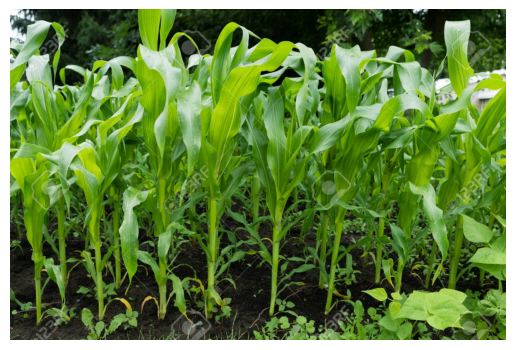

In [48]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def predecir_enfermedad(ruta_imagen):
    # 1. Cargar y redimensionar
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(2400, 2400))
    
    # 2. Convertir a array y aplicar PREPROCESAMIENTO CORRECTO
    img_array = tf.keras.utils.img_to_array(img)
    img_array = preprocess_input(img_array)  # ¡Clave para EfficientNet!
    img_array = tf.expand_dims(img_array, 0)
    
    # 3. Predecir
    pred = model.predict(img_array)
    clase_predicha = np.argmax(pred)
    confianza = np.max(pred) * 100
    
    # 4. Mapear clases
    clases = {v: k.replace('___', ' ') for k, v in data_gen_entrenamiento.class_indices.items()}
    
    return f"Predicción: {clases[clase_predicha]} ({confianza:.2f}% de confianza)"

# Ejemplo de uso
print(predecir_enfermedad("/Users/richardmacairm1/Downloads/86896213-plantas-de-maíz-sanas-y-otras-verduras-que-crecen-en-el-suelo.jpg"))
import matplotlib.pyplot as plt
img = plt.imread("/Users/richardmacairm1/Downloads/86896213-plantas-de-maíz-sanas-y-otras-verduras-que-crecen-en-el-suelo.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

In [43]:
print("Clases que el modelo conoce:", data_gen_entrenamiento.class_indices)


Clases que el modelo conoce: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicción: Healthy (79.02% de confianza)


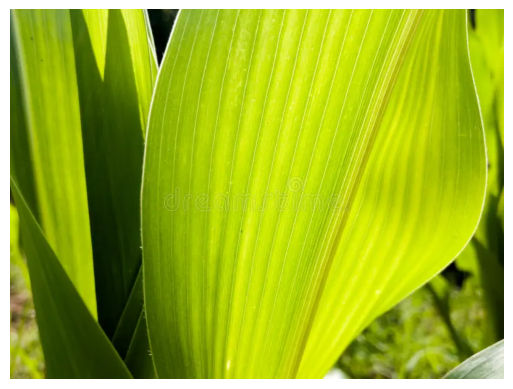

In [46]:
def predecir_enfermedad(ruta_imagen):
    # 1. Cargar y redimensionar
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(1200, 1200))
    
    # 2. Convertir a array y aplicar PREPROCESAMIENTO CORRECTO
    img_array = tf.keras.utils.img_to_array(img)
    img_array = preprocess_input(img_array)  # ¡Clave para EfficientNet!
    img_array = tf.expand_dims(img_array, 0)
    
    # 3. Predecir
    pred = model.predict(img_array)
    clase_predicha = np.argmax(pred)
    confianza = np.max(pred) * 100
    
    # 4. Mapear clases
    clases = {v: k.replace('___', ' ') for k, v in data_gen_entrenamiento.class_indices.items()}
    
    return f"Predicción: {clases[clase_predicha]} ({confianza:.2f}% de confianza)"

# Ejemplo de uso
print(predecir_enfermedad("/Users/richardmacairm1/Downloads/detalle-de-la-hoja-maíz-verde-con-patrón-vena-vertical-sana-planta-agrícola-agricultura-orgánica-208307512.webp"))
import matplotlib.pyplot as plt
img = plt.imread("/Users/richardmacairm1/Downloads/detalle-de-la-hoja-maíz-verde-con-patrón-vena-vertical-sana-planta-agrícola-agricultura-orgánica-208307512.webp")
plt.imshow(img)
plt.axis('off')
plt.show()